# EA Assignment 03 - Text Classification Model
__Authored by: Álvaro Bartolomé del Canto (alvarobartt @ GitHub)__

---

<img src="https://media-exp1.licdn.com/dms/image/C561BAQFjp6F5hjzDhg/company-background_10000/0?e=2159024400&v=beta&t=OfpXJFCHCqdhcTu7Ud-lediwihm0cANad1Kc_8JcMpA">

We will start this Jupyter Notebook with a little recap from the previous one named `02 - Data Preprocessing.ipynb` where we defined the NLP Preprocessing pipeline we want to apply in order to prepare the input raw text into valuable text, at the end of that Jupyter Notebook we dumped the generated `pandas.DataFrame` into a JSON-Lines file so as to avoid preprocessing the data on each Notebook. So on, this Jupyter Notebook starts with the preprocessed data loading, which means that if you want to have more details/insights on how the data is being preprocessed just refer to the previous notebook.

## Loading PreProcessed Data

__Reproducibility Warning__: you will not find the `PreProcessedDocuments.jsonl` file when cloning the repository from GitHub, since it has been included in the .gitignore file due to the GitHub quotas when uploading big files. So on, if you want to reproduce this Jupyter Notebook, please refer to `02 - Data Preprocessing.ipynb` where the NLP preprocessing pipeline is explained and this file is generated.

In [1]:
import json

data = list()

with open('PreProcessedDocuments.jsonl', 'r') as f:
    for line in f.readlines():
        data.append(json.loads(line))

In [2]:
import pandas as pd

data = pd.DataFrame(data)
data.head()

,lang,context,preprocessed_text
0,en,wikipedia,watchmen twelve issue comic book limited serie...
1,en,wikipedia,citigroup center formerly citicorp center tall...
2,en,wikipedia,birth_place death_date death_place party conse...
3,en,wikipedia,marbod maroboduus born died king marcomanni no...
4,en,wikipedia,sylvester medal bronze medal awarded every yea...


---

## Data Preparation

Before proceeding with the text vectorization, etc. we first need to encode the target values, since the `context` column of the `pandas.DataFrame`, which contains the previosuly preprocessed data, is a categorical variable which means that some models may have problems while handling it, so we will just turn it into an integer value, since models use to perform better with numerical data rather than categorical.

We will be using `sklearn.preprocessing.LabelEncoder`, which receives an array containing all the values and it just transforms every str occurrence into an int64 one.

In [3]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

In [4]:
data['context_id'] = encoder.fit_transform(data['context'])

__Note__: once we use the encoder to transform the `context` data, we need to store the relationship between the real context values and the numerical values assigned, so we will just dump a Python dictionary containing those relations, so as to later be able to tell that whenever the model is predicting 3, it is indeed predicting the Wikipedia's context.

In [5]:
contexts = data['context'].unique().tolist()
contexts

['wikipedia', 'conference_papers', 'apr', 'pan11']

In [6]:
ID2CONTEXT = {}

for context in contexts:
    ID2CONTEXT[int(encoder.transform([context])[0])] = context
    
ID2CONTEXT

{3: 'wikipedia', 1: 'conference_papers', 0: 'apr', 2: 'pan11'}

In [7]:
with open('resources/id2context.json', 'w') as f:
    json.dump(ID2CONTEXT, f)

Additionally, we will also need to turn the data from the `pandas.DataFrame` into `numpy.ndarray` objects, since sklearn models perform better with numpy data since it is standarized.

So on, we will just create the X variable which contains the preprocessed text dividing the words with spaces, and the y variable which is indeed the target variable plus the language.

The transformation of the y variable may seem confusing since we are including the language, but we are just doing it like that so as to split the data in a balanced way so that we ensure that the model receives not just data from each context, but data from each language, even though as already said and specified in the project's requirements, the text classification will be done regardless the language.

In [8]:
import numpy as np

X = np.asarray(data['preprocessed_text'])
y = np.asarray(data[['context_id', 'lang']])

---

## Pipeline Definition (Vectorizer & Classification Model)

One of the main features of sklearn are the Pipelines (`sklearn.pipeline.Pipeline`) which let you specify the setps from the data preprocessing to the model training and then easily import is as a Pipeline so as not to keep the trace of all the intermediate steps performed.

In this concrete case, since we are facing a NLP Text Classification problem, we need to define a vectorizer so as to transform the input text (already preprocessed) into a vector and then train a model which is being feed with those vectors.

### TF-IDF Vectorizer

There are multiple options when it comes to text vectorization such as `sklearn.feature_extraction.text.TfidfVectorizer`, `sklearn.feature_extraction.text.CountVectorizer` or `sklearn.feature_extraction.text.HashingVectorizer`, but in this case we will just be using the TF-IDF Vectorizer since it is the most suitable towards tackling this problem, since it ponderates the number of occurrences of each word inside a document with the number of occurrences of that word among all the other documents, so as to identify the relevance of a word appearing in a document towards later predict the context in which that concrete piece of text should be classified. 

`sklearn.feature_extraction.text.TfidfVectorizer` converts a collection of raw documents to a matrix of TF-IDF features, as stated in the scikit-learn docs.

So on, each row in the matrix corresponds to a single document and the indices of each row correspond to all of the unique words found accross all the documents, so on, if we have 10 documents and 100 unique words accross all those documents, we will have a TF-IDF matrix with shape (10, 100). Also, note that the value that is contained in each position of the row is 0 if that word does not appear in that document, and if it does it is the result of calculating the TF-IDF value.

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

In [10]:
texts = [
    'i would love to work at ea',
    'me encantaria trabajar en ea',
    'je adorerais travailler chez ea'
]

matrix = vectorizer.fit_transform(texts)

pd.DataFrame(matrix.todense(), index=texts, columns=vectorizer.get_feature_names())

,adorerais,at,chez,ea,en,encantaria,je,love,me,to,trabajar,travailler,work,would
i would love to work at ea,0.000000,0.432385,0.000000,0.255374,0.000000,0.000000,0.000000,0.432385,0.000000,0.432385,0.000000,0.000000,0.432385,0.432385
me encantaria trabajar en ea,0.000000,0.000000,0.000000,0.283217,0.479528,0.479528,0.000000,0.000000,0.479528,0.000000,0.479528,0.000000,0.000000,0.000000
je adorerais travailler chez ea,0.479528,0.000000,0.479528,0.283217,0.000000,0.000000,0.479528,0.000000,0.000000,0.000000,0.000000,0.479528,0.000000,0.000000


### Classification Models

Since we are facing a Text Classification model, once the vectorization is completed we should just decide which classification model to use depending on both the scope and the model's requirements/limitations. When it comes to NLP text classification, the most common scikit-learn models are `sklearn.naive_bayes.MultinomialNB`, `sklearn.ensemble.RandomForestClassifier`, `sklearn.svm.LinearSVC` and `sklearn.linear_model.LogisticRegression`.

Some considerations need to be made:

* `MultinomialNB` is more suitable when we apply a count vectorization, since it tends to perform better when the input vectors contain the number of total ocurrences of each word in each the document.

* The Random Forest models, in this case `RandomForestClassifier` are the most complex ones depending on the number of estimators (Decision Trees) used, and its result is the less consistent through the time, even though it is suppossed to be the most accurate one with good data since it combines the prediction of multiple models.

* Linear models such as `LinearSVC` and `LogisticRegression` also perform well when it comes to text classification from a TF-IDF input matrix.

So on, we will be evaluating some models in order to see their performance over unseen data with the default parameters so as to decide which model are we keeping before we proceed with the pipeline creation and hyper-parameter tuning.

__Note__: all this models will recieve the same input data which is indeed the transformed data using the `TfidfVectorizer` previously explained.

In [11]:
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

In [12]:
import warnings
warnings.filterwarnings('ignore')

from time import time

__Reproducibility Warning__: the follwing Jupyter Notebook cell may take too long, since it trains multiple models multiple times in order to retrieve some evaluation metrics so as to decide which is the best model. So on, since this part has been just made with research purposes, you can jump straight forward to the next section which is _Pipeline_.

In [13]:
train_test = StratifiedShuffleSplit(n_splits=5, test_size=.2)

results = list()

for train_index, test_index in train_test.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index][:,0], y[test_index][:,0]
    
    y_train = y_train.astype(int)
    y_test = y_test.astype(int)

    vect = TfidfVectorizer(min_df=5)
    
    X_train = vect.fit_transform(X_train)
    X_test = vect.transform(X_test)
    
    for model in (MultinomialNB(), LogisticRegression(), RandomForestClassifier(), LinearSVC(),):
        start = time()
        model.fit(X_train, y_train)
        stop = time()
        
        results.append({
            'model': model.__class__.__name__,
            'val_accuracy': model.score(X_test, y_test),
            'training_time': stop - start
        })
        
results = pd.DataFrame(results)

Now we will just plot all the retrived results into a Box Plot using both `matplotlib` and `seaborn` in order to show the models performance in the 5 different stratified folds, which will not just reveal the most accurate one on the validation/test data but will also reveal which are the most consistent models no matter the fold.

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style='whitegrid')

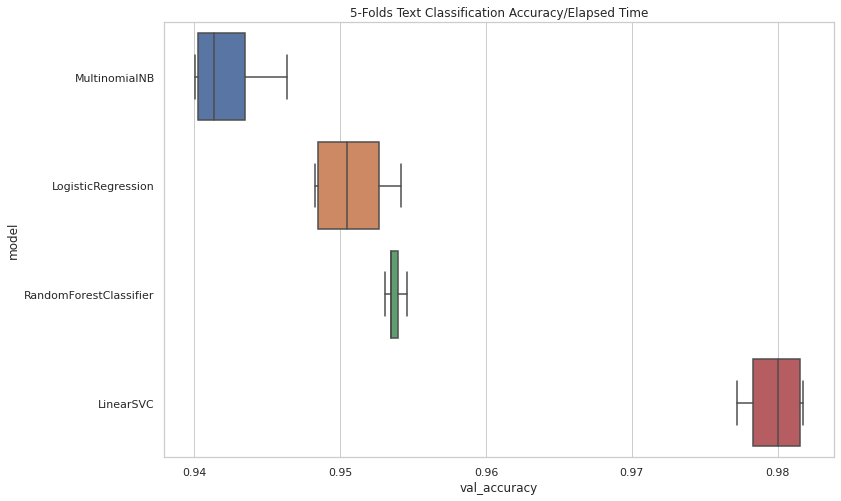

In [15]:
plt.figure(figsize=(12,8));
sns.boxplot(x='val_accuracy', y="model", data=results);
plt.title("5-Folds Text Classification Accuracy/Elapsed Time");

As we can see, the `LinearSVC` outperforms the other models even though all the models seem to have pretty accurate results as the minimum validation/test accuracy was achieved by the `MultinomialNB` with a value of ~94%. Anyway, the `LinearSVC` has obtained more than 98.5% on each validation/test fold, being the most consistent and accurate; while the other models are up to 1.5% behind on accuracy. Both `LogisticRegression` and `RandomForestClassifier` are pretty close on accuracy even though the last one is a little bit better.

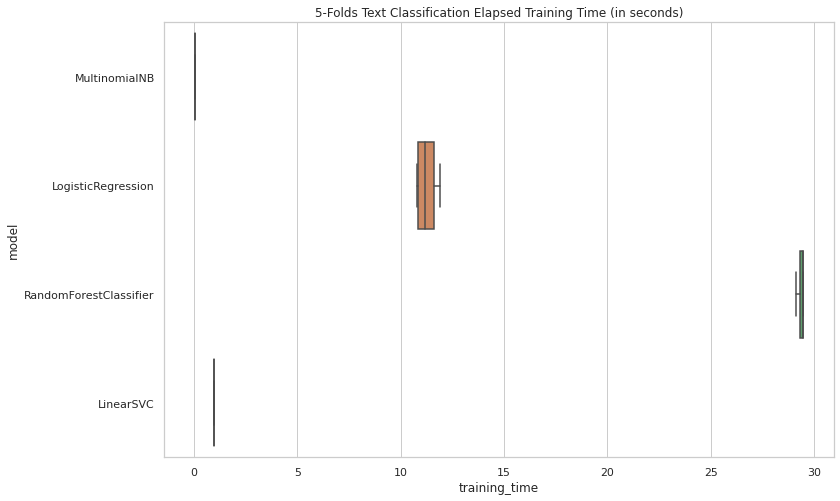

In [16]:
plt.figure(figsize=(12,8));
sns.boxplot(x='training_time', y="model", data=results);
plt.title("5-Folds Text Classification Elapsed Training Time (in seconds)");

Another aspect to take into consideration is the training time, which in the case of the `RandomForestClassifier` is the highest one as we previously stated since it is the most complex one, while the best models when it comes to training time are: `MultinomialNB` and `LinearSVC`, where the last one takes a little bit more training time than the first one, but is still below 2 seconds which is pretty nice.

All this features make the `LinearSVC` the best model towards this current problem, so we will proceed to the Pipeline definition using both the TD-IDF Vectorizer and the Linear Support Vector Classification Model, which is required their hyper parameters will be tuned in order to achieve a higher validation accuracy.

### Pipeline Implementation

Finally, we will implement the sklearn Pipeline with the previous conclusions, which means that the pipeline should consist on a first layer/step in order to vectorize the input preprocessed text so as to transform it into a TF-IDF sparse matrix, which will later be used to train the Linear Support Vector Classification model.

Also note that the data (X and y) should be split into training and validation/testing datasets, so as to have a collection of balanced (per context and language) preprocessed texts and their respective contexts, which are indeed, the categories that the model is intended to predict.__Note__: balancing the dataset by context and by language is strictly required, since a random split could not work as expected, this way we ensure that the model receives data from every possible context and language as input so as to prevent that validation/testing/unseen data is not represented.

__Note__: balancing the dataset by context and by language is strictly required, since a random split could not work as expected, this way we ensure that the model receives data from every possible context and language as input so as to prevent that validation/testing/unseen data is not represented.

In [17]:
train_test = StratifiedShuffleSplit(n_splits=5, test_size=.2, random_state=42)

for train_index, test_index in train_test.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index][:,0], y[test_index][:,0]

y_train = y_train.astype(int)
y_test = y_test.astype(int)

In [18]:
X_train.shape, y_train.shape

((18408,), (18408,))

In [19]:
X_test.shape, y_test.shape

((4603,), (4603,))

Before proceeding with the hyper parameter tuning using `sklearn.model_selection.GridSearchCV` over the `sklearn.pipeline.Pipeline` we will evaluate the model first, since maybe the default model achieves a high accuracy as shown above and no hyper parameter tuning is required.

In [20]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('vect', TfidfVectorizer(min_df=5)),
    ('clf', LinearSVC())
])

In [21]:
%time pipeline.fit(X_train, y_train);

CPU times: user 6.77 s, sys: 65.8 ms, total: 6.84 s
Wall time: 6.84 s


Pipeline(steps=[('vect', TfidfVectorizer(min_df=5)), ('clf', LinearSVC())])

### Pipeline Dump

Once is fitted, we will just dump it into a .joblib file so as to use it in the upcoming Jupyter Notebook where we will be testing the model over some data we retrieve from the Internet so as to check that the validation accuracy matches the reality, as it is useless to achieve a high validation accuracy if then the model over unseen real data performs worst.

__Reproducibility Warning__: For dumping the model we will use `joblib` as already specified, but in order to reproduce it (both pipeline dump and load) make sure that you have the following Python libraries installed in the specified version: `scikit-learn==0.23.1 joblib==0.16.0`, otherwise we can not ensure that the dumped model works for you.

In [22]:
from joblib import dump

dump(pipeline, 'resources/text-classification-pipeline.joblib')

['resources/text-classification-pipeline.joblib']

---

## Pipeline Evaluation

So as to complete the Text Classification Model research, we will evaluate the previously trained Pipeline, so as to get more insights on its performance rather than the accuracy/score or the time elapsed, even though we will just start by printing the Pipeline's accuracy over the training and the validation data so as to see its performance mainly over unseen data (validation/testing data).

In [23]:
print(f"Training Accuracy: {pipeline.score(X_train, y_train)}")
print(f"Validation Accuracy: {pipeline.score(X_test, y_test)}")

Training Accuracy: 1.0
Validation Accuracy: 0.9834890288941994


As we can see, the results are pretty good, since we obtained a Pipeline for Multi-Lingual Multi-Context Text Classification with over 98% accuracy on both training and validation data, so the trained Pipeline seems to be pretty consistent according to the accuracy evaluation metric.

Anyway, in order to ensure that the Pipeline's performance is as good as it seems we will print the sklearn classification report, which will present some of the main metrics to take into consideration of classification problems.

In [24]:
prediction = pipeline.predict(X_test)

In [25]:
from sklearn.metrics import classification_report

print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1182
           1       0.98      0.91      0.94       121
           2       0.99      0.94      0.97       582
           3       0.98      1.00      0.99      2718

    accuracy                           0.98      4603
   macro avg       0.99      0.96      0.97      4603
weighted avg       0.98      0.98      0.98      4603



And, as expected, both the precision/accuracy and the recall are pretty high which favours the F1 scores of the model so that it is pretty close to them both so we can just take the F1 Score into consideration after evaluating that both precision and recall are high, since it is usual that just one of them is high while the other is a little bit worse.

Additionally, in order to complement the classification report, we will be plotting the confusion matrix which will ease the detection of the True Positives rate, which are the correctly classified samples. Anyway, we are expecting this values to be high as we already saw their scores, but now we do not want to see "how good it is" since we are done with it. What we really want to see with the confusion matrix visualization is which concrete samples are missclassified and which are contexts that usually get missclassified so as to extract some useful conclusions.

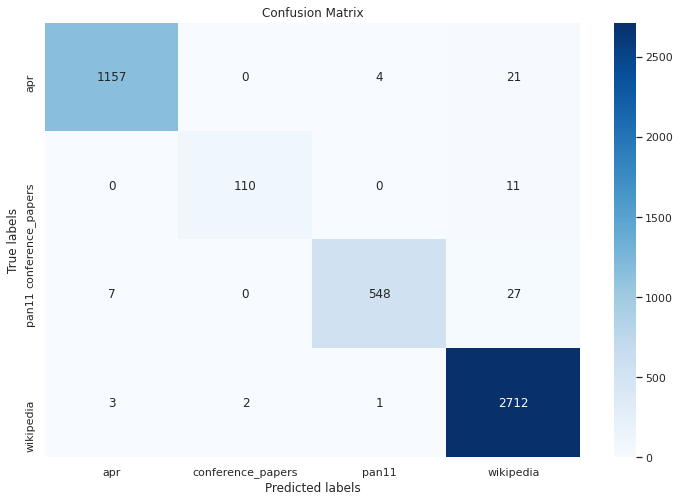

In [26]:
from sklearn.metrics import confusion_matrix

fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(confusion_matrix(y_test, prediction), annot=True, fmt="d", ax=ax, cmap='Blues');
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels([ID2CONTEXT[i] for i in range(len(contexts))]);
ax.yaxis.set_ticklabels([ID2CONTEXT[i] for i in range(len(contexts))]);

So on, as the confusion matrix reveals, the main false positives and false negatives are almost always releated to the Wikipedia context, since it is the most populated context, and the trend is to predict Wikipedia when it is not Wikipedia. Also, it can be seen that the Conference Papers and the APR texts are never missclassified each other.

Anyway, it can also be seen that just a few samples are missclassified which as opposed to the correctly classified samples does not need to be taken into consideration.